In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, morphology

In [57]:
def shape_aa(
    structuring_element, target_shape
) -> np.ndarray:
    """Resize the filter to the desired shape and smooth it if required."""
    return transform.resize(
        structuring_element,
        target_shape,
        preserve_range=True,
        anti_aliasing=True,
    )
    
def center_in(
    center: np.ndarray, filter_shape, dtype: str = "float64"
) -> np.ndarray:
    """Pad the computed center form to match the desired filter shape."""
    pad_before = (filter_shape[0] - center.shape[0]) // 2, (
        filter_shape[1] - center.shape[1]
    ) // 2
    pad_after = filter_shape[0] - pad_before[0], filter_shape[1] - pad_before[1]

    centered = np.zeros(shape=filter_shape, dtype=dtype)
    centered[
        pad_before[0] : pad_after[0], pad_before[1] : pad_after[1]
    ] = center

    return centered


In [58]:
def draw(radius):
    dim = radius * 2 + 1
    disk = morphology.disk(3 * 2 + 1).astype(np.float64)
    disk = shape_aa(disk, (3 * 2 + 1, 3 * 2 + 1))

    diam = morphology.diamond(2 * 2 + 1).astype(np.float64)
    diam = shape_aa(diam, (2 * 2 + 1, 2 * 2 + 1))

    res = center_in(disk, (7, 7)) - center_in(diam, (7, 7))

    name = f"complex_{radius}"
    np.save(name + ".npy", res)
    plt.imshow(res, cmap="plasma")
    plt.colorbar()
    plt.savefig(name + ".png")
    print(res.dtype)

float64


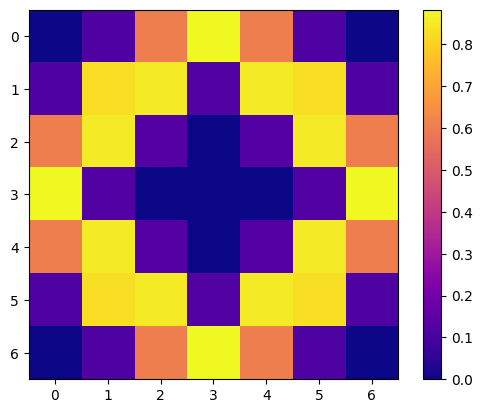

In [59]:
draw(0)

In [34]:
def draw_disk(radius, shape=None, dtype="float32"):
    from skimage import morphology

    res = morphology.disk(radius).astype(dtype)
    if shape is not None:
        return center_in(res, shape)
    return res


def draw_diamond(radius, shape=None, dtype="float32"):
    from skimage import morphology

    res = morphology.diamond(radius).astype(dtype)
    if shape is not None:
        return center_in(res, shape)
    return res

def center_in(arr, shape, dtype="float32"):
    res = np.zeros(shape=shape, dtype=dtype)
    pad_before = (shape[0] - arr.shape[0]) // 2, (shape[1] - arr.shape[1]) // 2
    pad_after = shape[0] - pad_before[0], shape[1] - pad_before[1]
    res[pad_before[0] : pad_after[0], pad_before[1] : pad_after[1]] = arr
    return res


def shape_aa(original, target_shape):
    from skimage import transform

    return transform.resize(
        original, target_shape, preserve_range=True, anti_aliasing=True
    )


def draw_disk_aa(radius, shape=None, dtype="float32"):
    from skimage import transform

    dim = radius * 2 + 1
    res = draw_disk(dim, dtype=dtype)
    res = shape_aa(res, (dim, dim))

    if shape is not None:
        return center_in(res, shape)
    return res


def draw_diamond_aa(radius, shape=None, dtype="float32"):
    dim = radius * 2 + 1
    res = draw_diamond(dim, dtype=dtype)
    res = shape_aa(res, (dim, dim))

    if shape is not None:
        return center_in(res, shape, dtype=dtype)
    return res


def draw_complex(shape=None, dtype="float32"):
    return draw_disk_aa(3, shape, dtype=dtype) \
           - draw_diamond_aa(2, shape, dtype=dtype)

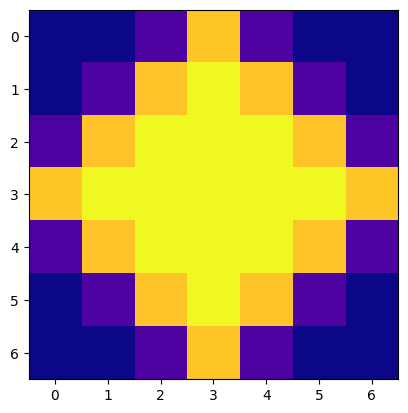

In [42]:
plt.imshow(draw_diamond_aa(3, (7, 7)), cmap="plasma")

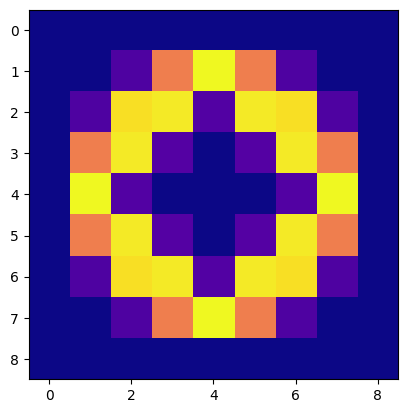

In [54]:
plt.imshow(draw_complex((9, 9)), cmap="plasma")

In [71]:
import torchvision
from scipy import ndimage

In [62]:
data = torchvision.datasets.MNIST("../mnist/", train=False).data

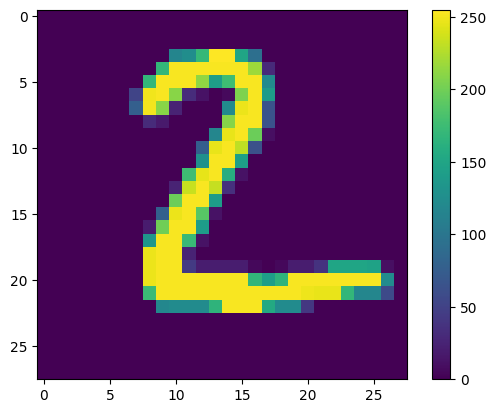

In [121]:
plt.imshow(data[1])
plt.colorbar()

(10, 28, 28)


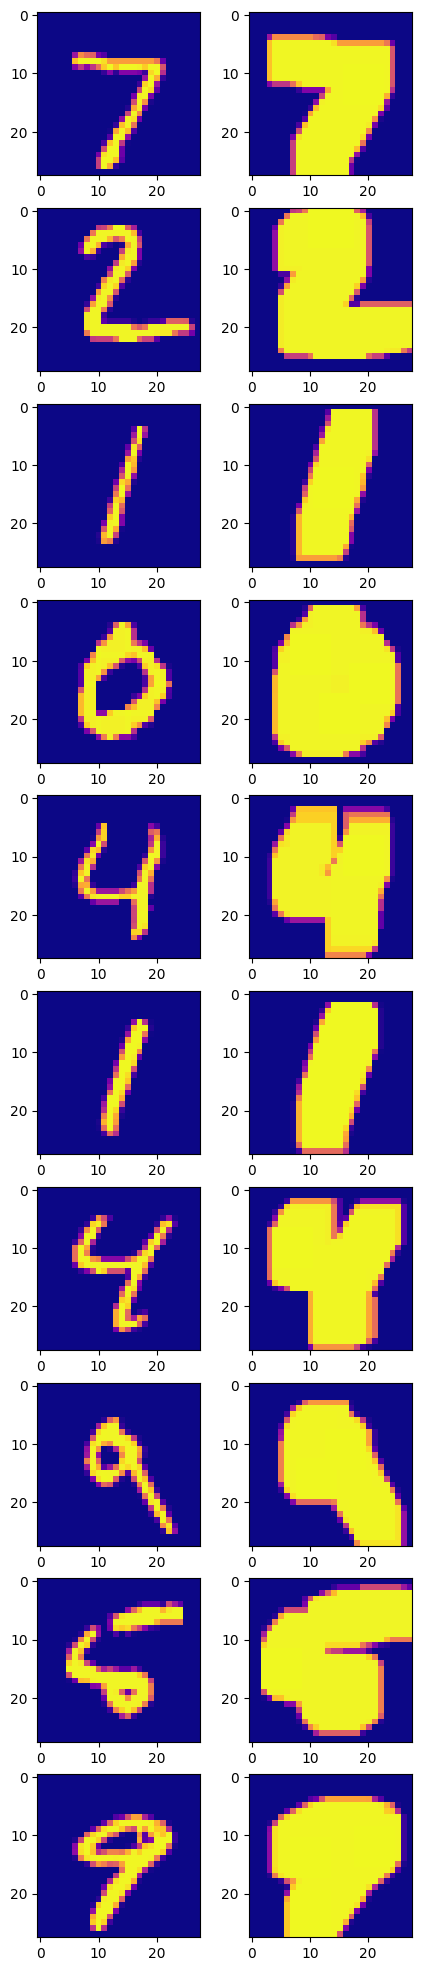

In [93]:
plt.figure(figsize=(5, 25))
res = []
for i in range(10):
    res.append(ndimage.grey_dilation(data[i], structure=draw_complex((7, 7))))

res = np.array(res)
print(res.shape)
for i in range(10):
    plt.subplot(10, 2, 1 + 2 * i)
    plt.imshow(data[i], cmap="plasma")
    plt.subplot(10, 2, 2 + + 2 * i)
    plt.imshow(res[i], cmap="plasma")
plt.savefig("dilations.png")
# np.save("images.npy", data[:10])
np.save("dilations.npy", res)

In [94]:
import pickle

dict_keys(['network_outputs', 'layers_weights'])
(1, 'SMorph', {'filter': tensor([[[[-1.2974,  0.0603,  0.4218,  0.6370,  0.4224,  0.0295, -0.1067],
          [ 0.0633,  0.5834,  0.5482, -0.6019,  0.5664,  0.5830,  0.0365],
          [ 0.4294,  0.5443,  0.4972,  0.2115, -0.7140,  0.5605,  0.4312],
          [ 0.6417, -0.3426, -0.3604,  0.5270,  0.4653, -0.3920,  0.6414],
          [ 0.4337,  0.5573, -0.6908,  0.0837,  0.4962,  0.5464,  0.4297],
          [ 0.0318,  0.5839,  0.5683, -0.5511,  0.5507,  0.5854,  0.0335],
          [-0.1067,  0.0320,  0.4179,  0.6342,  0.4214,  0.0288, -0.1166]]]]), 'alpha': tensor([[6.5081]])})


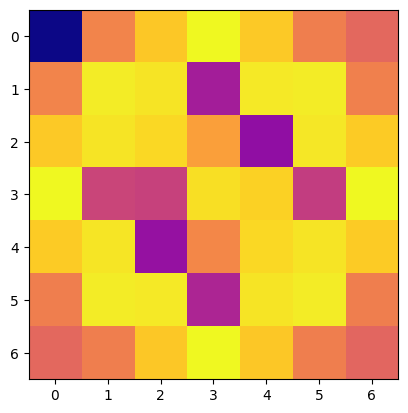

In [143]:
with open("/lrde/home2/rdi-2022/rhermary/update_morphonet/src/mlruns/0/a621e6db96fa4baaa4a78dfff99804f2/artifacts/outputs/000074.pickle", "rb") as f:
    out = pickle.load(f)
    print(out.keys())
    # print(out['network_outputs'][-1][2])
    print(out['layers_weights'][1])
    # print(out['inputs'].shape)
    # plt.imshow(out['network_outputs'][-1][2][0, 0].cpu(), cmap="plasma")
    plt.imshow(out['layers_weights'][1][-1]['filter'].cpu().squeeze(), cmap="plasma")
    # plt.colorbar()

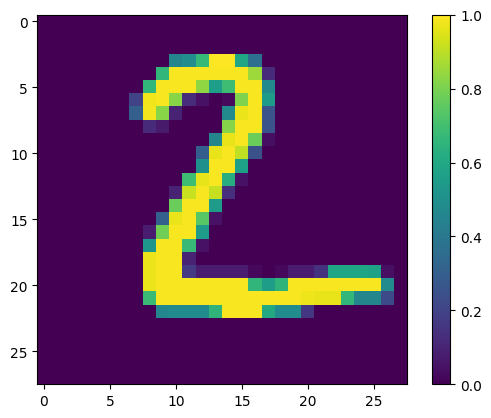

In [130]:
with open("/lrde/home2/rdi-2022/rhermary/update_morphonet/src/val_in.npy", "rb") as f:
    a = np.load(f)
    plt.imshow(a[1, 0])
    plt.colorbar()